Text(0.5, 0, 'Lateral Acceleration (g)')

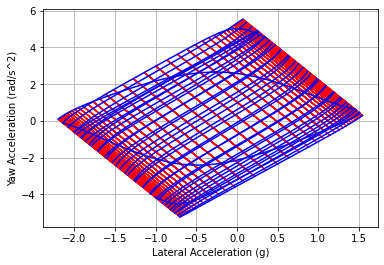

In [1]:
from suspension import Suspension
from vehicle import Vehicle
from aerodynamics import Aerodynamics
import math as deez_nuts
from scipy.optimize import fsolve as josie_solver
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("MMM.csv")

for x in df["body_slip"].unique():
    df2 = df[df["body_slip"] == x]
    plt.plot(df2["y_double_dot"]/9.81, df2["yaw_acceleration"], 'r')

for x in df["steered_angle"].unique():
    df2 = df[(df["steered_angle"] == x)]
    plt.plot(df2["y_double_dot"]/9.81, df2["yaw_acceleration"], 'b')

plt.grid()
plt.ylabel("Yaw Acceleration (rad/s^2)")
plt.xlabel("Lateral Acceleration (g)")